# Create counterfactual data

This notebook walks through two custom functions for creating a counterfactual data that lets us localize a high level variable (circularity, color, or area) in a neural network.

It goes through:
1. **Single source counterfactual**: one source for many variables
2. **Multi-source counterfactual**: different sources for different variables

In [ ]:
!pip install -r requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
_ = torch.manual_seed(42)
# _ = torch.cuda.manual_seed(42) # only if using GPU

## 1. Single source counterfactual: one source for many variables

This counterfactual data can help us map a subspace of neurons that localize a *combination* of variables (e.g., neurons 54-62 localize circularity & color together).

In [3]:
# example variables that we want to localize/intervene on
variables = [0, 1]

In [4]:
from data_utils import create_dataset
from counterfactual_data_utils import create_single_source_counterfactual_dataset

# first, create base dataset
n_train = 10000
images, labels = create_dataset(n_train)
coefficients = np.array([0.4, 0.4, 0.4])

# create single source counterfactual dataset
# NOTE: the counterfactual dataset can be made much larger than the base dataset, bc it consists of 10000 x 10000 pairs of possible samples
X_base, X_sources, y_base, y_sources, y_counterfactual, base_labels, source_labels = create_single_source_counterfactual_dataset(
    variables, images, labels, coefficients, size=50000, return_labels=True
)

Visualizing an example base-source pair and resulting labels. *(Note: I use `R` to refer to "roundness" or circularity)*

In [5]:
# toggle i to see different examples
i = 42

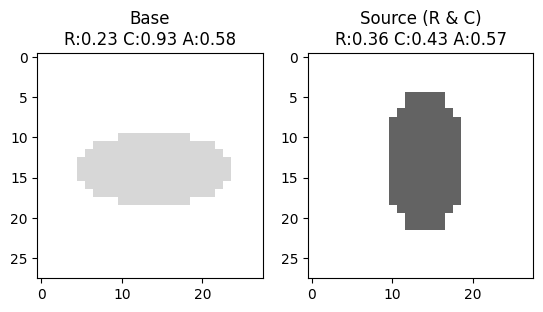

In [6]:
# Print elements from the data set and their labels under various weights to make sure everything is kosher
import matplotlib.pyplot as plt

# Set up the figure and axes for plotting
fig, axes = plt.subplots(1, 2)  # 2 rows, 5 columns, adjust size as needed

# Flatten the axes array for easier indexing with a flat loop
axes = axes.flatten()

_ = axes[0].imshow(X_base[i].squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
_ = axes[0].set_title(f'Base\nR:{round(base_labels[i][0].item(), 2)} C:{round(base_labels[i][1].item(), 2)} A:{round(base_labels[i][2].item(), 2)}')
_ = axes[1].imshow(X_sources[0][i].squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
_ = axes[1].set_title(f'Source (R & C)\nR:{round(source_labels[0][i][0].item(), 2)} C:{round(source_labels[0][i][1].item(), 2)} A:{round(source_labels[0][i][2].item(), 2)}')

The label is computed by taking a weighted sum, where the values for `R` (circularity) and `C` (color) come from the source, and the value for the remaining variable (area) comes from the base.

In [7]:
print(f'Base label: 0.4 * {round(base_labels[i][0].item(), 2)} + 0.4 * {round(base_labels[i][1].item(), 2)} + 0.4 * {round(base_labels[i][2].item(), 2)} > 0.6 --> {y_base[i].item()}')
print(f'Source (R & C) label: 0.4 * {round(source_labels[0][i][0].item(), 2)} + 0.4 * {round(source_labels[0][i][1].item(), 2)} + 0.4 * {round(source_labels[0][i][2].item(), 2)} > 0.6 --> {y_sources[0][i].item()}')
print()
print(f'Counterfactual label: 0.4 * {round(source_labels[0][i][0].item(), 2)} + 0.4 * {round(source_labels[0][i][1].item(), 2)} + 0.4 * {round(base_labels[i][2].item(), 2)} > 0.6 --> {y_counterfactual[i].item()}')

Base label: 0.4 * 0.23 + 0.4 * 0.93 + 0.4 * 0.58 > 0.6 --> 1.0
Source (R & C) label: 0.4 * 0.36 + 0.4 * 0.43 + 0.4 * 0.57 > 0.6 --> 0.0

Counterfactual label: 0.4 * 0.36 + 0.4 * 0.43 + 0.4 * 0.58 > 0.6 --> 0.0


Sanity check: labels are balanced in counterfactual dataset

In [8]:
print(f'Rate of positive base examples: {y_base.mean().item():.3f}', )
print(f'Rate of positive source examples (R & C): {y_sources[0].mean().item():.3f}')
print(f'Rate of positive counterfactual examples: {y_counterfactual.mean().item():.3f}')

Rate of positive base examples: 0.500
Rate of positive source examples (R & C): 0.502
Rate of positive counterfactual examples: 0.500


## 2. Multi-source counterfactual: different sources for different variables

Multi-source interventions can help *disentangle* the neural representations of multiple variables (e.g., neurons 54-58 localize circularity, neurons 58-62 localize color).

In [9]:
# example variables that we want to localize/intervene on
variables = [0, 1]

In [10]:
from data_utils import create_dataset
from counterfactual_data_utils import create_multi_source_counterfactual_dataset

# first, create base dataset
n_train = 10000
images, labels = create_dataset(n_train)
coefficients = np.array([0.4, 0.4, 0.4])

# create multi-source counterfactual dataset
X_base, X_sources, y_base, y_sources, y_counterfactual, base_labels, source_labels = create_multi_source_counterfactual_dataset(
    variables, images, labels, coefficients, size=50000, return_labels=True
)

In [11]:
# toggle i to see different examples
i = 42

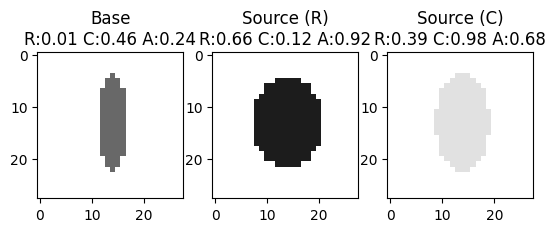

In [12]:
# Print elements from the data set and their labels under various weights to make sure everything is kosher
import matplotlib.pyplot as plt

# Set up the figure and axes for plotting
fig, axes = plt.subplots(1, 3)  # 2 rows, 5 columns, adjust size as needed

# Flatten the axes array for easier indexing with a flat loop
axes = axes.flatten()

_ = axes[0].imshow(X_base[i].squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
_ = axes[0].set_title(f'Base\nR:{round(base_labels[i][0].item(), 2)} C:{round(base_labels[i][1].item(), 2)} A:{round(base_labels[i][2].item(), 2)}')
_ = axes[1].imshow(X_sources[0][i].squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
_ = axes[1].set_title(f'Source (R)\nR:{round(source_labels[0][i][0].item(), 2)} C:{round(source_labels[0][i][1].item(), 2)} A:{round(source_labels[0][i][2].item(), 2)}')
_ = axes[2].imshow(X_sources[1][i].squeeze(), cmap='gray', interpolation='nearest', vmin=0, vmax=1)
_ = axes[2].set_title(f'Source (C)\nR:{round(source_labels[1][i][0].item(), 2)} C:{round(source_labels[1][i][1].item(), 2)} A:{round(source_labels[1][i][2].item(), 2)}')

The label is computed by taking a weighted sum, where the value for `R` (circularity) comes from the first source, the value for `C` (color) comes from the second source, and the value for the remaining variable (area) comes from the base.

In [13]:
print(f'Base label: 0.4 * {round(base_labels[i][0].item(), 2)} + 0.4 * {round(base_labels[i][1].item(), 2)} + 0.4 * {round(base_labels[i][2].item(), 2)} > 0.6 --> {y_base[i].item()}')
print(f'Source (R) label: 0.4 * {round(source_labels[0][i][0].item(), 2)} + 0.4 * {round(source_labels[0][i][1].item(), 2)} + 0.4 * {round(source_labels[0][i][2].item(), 2)} > 0.6 --> {y_sources[0][i].item()}')
print(f'Source (C) label: 0.4 * {round(source_labels[1][i][0].item(), 2)} + 0.4 * {round(source_labels[1][i][1].item(), 2)} + 0.4 * {round(source_labels[1][i][2].item(), 2)} > 0.6 --> {y_sources[1][i].item()}')
print()
print(f'Counterfactual label: 0.4 * {round(source_labels[0][i][0].item(), 2)} + 0.4 * {round(source_labels[1][i][1].item(), 2)} + 0.4 * {round(base_labels[i][2].item(), 2)} > 0.6 --> {y_counterfactual[i].item()}')

Base label: 0.4 * 0.01 + 0.4 * 0.46 + 0.4 * 0.24 > 0.6 --> 0.0
Source (R) label: 0.4 * 0.66 + 0.4 * 0.12 + 0.4 * 0.92 > 0.6 --> 1.0
Source (C) label: 0.4 * 0.39 + 0.4 * 0.98 + 0.4 * 0.68 > 0.6 --> 1.0

Counterfactual label: 0.4 * 0.66 + 0.4 * 0.98 + 0.4 * 0.24 > 0.6 --> 1.0


Sanity check: labels are balanced in counterfactual dataset

In [14]:
print(f'Rate of positive base examples: {y_base.mean().item():.3f}', )
print(f'Rate of positive sources (R): {y_sources[0].mean().item():.3f}')
print(f'Rate of positive sources (C): {y_sources[1].mean().item():.3f}')
print(f'Rate of positive counterfactual examples: {y_counterfactual.mean().item():.3f}')

Rate of positive base examples: 0.501
Rate of positive sources (R): 0.501
Rate of positive sources (C): 0.500
Rate of positive counterfactual examples: 0.498
